# Explicación de DecisionTreeClassifier y KNN

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Octubre de 2024  
**Versión:** 1.0  

---

## Descripción

Este notebook muestra la creación de modelos predictivos para variables discretas usando algoritmos de clasificación.

En este caso se aplican 2 algoritmos:

+ DecisionTreeClassifier y se trabaja con dos de sus hiper parámetros: *max_depth* y *criterion*.
+ KNeighborsClassifier

Las métricas usadas en este modelo de clasificación son:

+ accuracy
+ precision_score
+ recall
+ F1 score
+ matriz de confusión
+ roc_auc
---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)
- sklearn (1.3.2)

Para verificar la versión instalada ejecutar usando el nombre del paquete del cual quieres saber la versión; por ejemplo, si quieres saber la versión de sklearn usas:

```bash
import sklearn
print(sklearn.__version__)
````


# Definiciones importantes

## ***1. Entropía***

En el contexto de los árboles de decisión es una medida de la incertidumbre o impureza en un conjunto de datos. Es utilizada para evaluar la calidad de una división o partición de los datos, con el objetivo de construir el árbol de decisión de manera óptima.

### Concepto de Entropía:

- En teoría de la información, la entropía mide la cantidad de desorden o aleatoriedad en un conjunto de datos. Para un problema de clasificación, refleja la probabilidad de que un ejemplo pertenezca a una clase específica.

- Si todas las instancias pertenecen a una sola clase (la partición es pura), la entropía es 0. Si las clases están distribuidas equitativamente, la entropía es máxima, lo que indica la mayor incertidumbre posible.

### Entropía en Árboles de Decisión:

- Los árboles de decisión buscan dividir los datos en subconjuntos que sean lo más puros posibles, es decir, que contengan la mayor cantidad de instancias de una sola clase.
- La entropía se usa para seleccionar el mejor atributo para dividir los datos. ***Cuanto menor sea la entropía después de una partición, mejor será la división.***
- El objetivo es maximizar la **ganancia de información**, que se calcula restando la entropía ponderada de los subconjuntos resultantes de una partición de la entropía del conjunto original. Esto indica la reducción en la incertidumbre lograda al dividir los datos en base a un atributo.

### Ejemplo:

Supongamos un conjunto de datos de clasificación con dos clases, "positivo" y "negativo":

- Si el conjunto tiene 50% positivo y 50% negativo, la entropía será máxima (equivalente a 1)), ya que hay alta incertidumbre.
- Si el conjunto es 100% positivo o 100% negativo, la entropía será 0, indicando una partición pura sin incertidumbre.

En los árboles de decisión, la entropía se utiliza para guiar la creación de divisiones que logren la mayor reducción en la incertidumbre, buscando obtener nodos homogéneos en cuanto a la clase de los ejemplos.

## ***2. ROC AUC***
El valor de **ROC AUC** (Receiver Operating Characteristic - Area Under the Curve) en clasificación mide la capacidad de un modelo para distinguir entre clases positivas y negativas. La interpretación es la siguiente:

1. **Definición básica**:
   - El **ROC** es una curva que muestra la relación entre la **tasa de verdaderos positivos** (TPR, o sensibilidad) y la **tasa de falsos positivos** (FPR) a medida que varía el umbral de decisión del modelo.
   - El **AUC (Area Under the Curve)** mide el área bajo esta curva. Es un valor que va de 0 a 1 y resume el rendimiento del modelo en un solo número.

2. **Interpretación del valor de AUC**:
   - **AUC = 1.0**: indica un modelo perfecto. El modelo es capaz de distinguir correctamente todas las instancias positivas de las negativas sin errores.
   - **AUC = 0.5**: indica un modelo que no tiene capacidad para clasificar mejor que el azar. La curva ROC sería una línea diagonal, lo que sugiere que el modelo no tiene poder discriminante.
   - **0.5 < AUC < 1.0**: cuanto más cerca esté de 1, mejor es el modelo para discriminar entre las clases. Un AUC más alto indica un mejor rendimiento del modelo en la clasificación de casos positivos frente a negativos.
   - **AUC < 0.5**: sugiere que el modelo tiene un desempeño peor que el azar y podría estar etiquetando incorrectamente las clases.

3. **Uso en la práctica**:
   - Un AUC más alto significa que, en promedio, el modelo asigna una probabilidad mayor a las instancias positivas que a las negativas.
   - Se utiliza para comparar diferentes modelos de clasificación; un modelo con un AUC más alto se considera mejor.

En resumen, el **ROC AUC** evalúa qué tan bien el modelo clasifica los casos positivos frente a los negativos, y un valor más alto indica un mejor desempeño.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,  classification_report

Utilizaremos un conjunto de datos de predicción de diabetes dado una serie de parámetros fisiológicos de un paciente.

In [ ]:
!wget https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv

--2024-10-26 19:09:57--  https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11 [following]
--2024-10-26 19:09:57--  https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf7a2a26935e1cf79afeaf57978.dl.dropboxusercontent.com/cd/0/inline/CdMnexLCYdH2CikyisgcRQFhFB26Pxsp1bfWWGzv0CCZQ_haWVCnbj_86tIcCzulJY1oQ59jl2a4TKnEfXbxfW1athZTpTQZC6WZfPEq92g2OBiOrVtbmxzlH_QkfKKPrHZAf4x8xq2yaKTqiRdaIYg-/file# [following]
--2024-10-26 19:09:58--  https://ucf7a2a26935e1cf79afeaf57978.dl.dropboxusercontent.com/cd/0/inline/C

In [ ]:
diabetes = pd.read_csv("diabetes.csv")

In [ ]:
diabetes.sample(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
124,0,113,76,0,0,33.3,0.278,23,1
318,3,115,66,39,140,38.1,0.150,28,0
522,6,114,0,0,0,0.0,0.189,26,0
521,3,124,80,33,130,33.2,0.305,26,0


In [ ]:
diabetes.Outcome.unique()

array([1, 0])

In [ ]:
diabetes.Outcome.value_counts()

,count
Outcome,
0,500
1,268


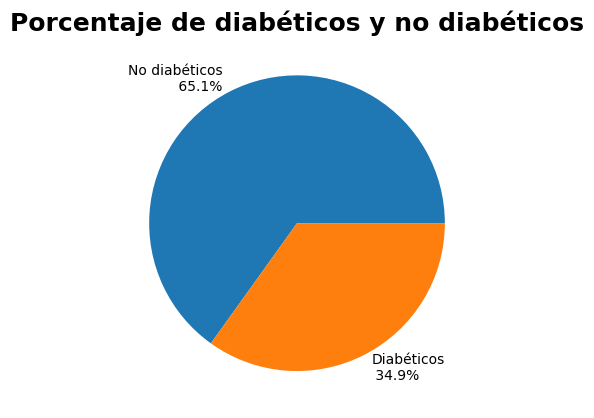

In [ ]:
# Gráfico de torta del porcentaje de pacientes diabéticos y no diabéticos
clases = np.array([diabetes[diabetes.Outcome == 0.0].shape[0],
                   diabetes[diabetes.Outcome == 1.0].shape[0]])

# Creando las leyendas del gráfico.
labels = [ str(round(x * 1.0 / clases.sum() * 100.0, 2)) + '%'  for x in clases ]
labels[0] = 'No diabéticos\n ' + labels[0]
labels[1] = 'Diabéticos\n ' + labels[1]

plt.pie(clases, labels=labels)
plt.title('Porcentaje de diabéticos y no diabéticos', fontsize=18, fontweight="bold")
plt.show()

Para ilustrar la construcción de un árbol de decisión utilizaremos sólo un par de variables del conjunto de datos.

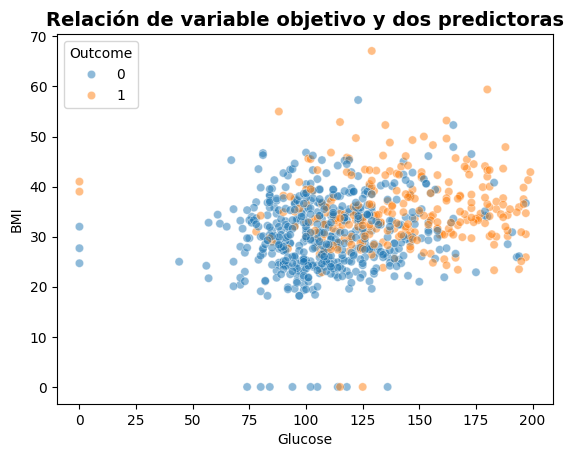

In [ ]:
sns.scatterplot(
    data = diabetes,
    x = "Glucose",
    y = "BMI",
    hue = "Outcome",
    alpha = 0.5
)
plt.title("Relación de variable objetivo y dos predictoras", fontsize=14, fontweight="bold")
plt.show()


---

***Observaciones***

---
Se observa la relación entre la variable objetivo (`Outcome`) y dos variables independientes (predictoras): `Glucose` (en el eje x) y `BMI` (en el eje y). Algunas interpretaciones posibles son:

1. **Distribución de los datos**:
   - Los puntos representan datos individuales, donde el color indica el valor de la variable de resultado (`Outcome`), con dos clases: 0 y 1.
   - La mayoría de los puntos se concentran en un rango de valores de `Glucose` entre 75 y 150, y de `BMI` entre 20 y 50.

2. **Separación entre clases**:
   - Aunque hay superposición en los datos, se pueden observar algunas tendencias. Por ejemplo, los puntos naranjos (que corresponden a la clase 1) parecen estar más presentes en las zonas con valores más altos de `Glucose`, lo que sugiere que las personas con resultados de `Outcome` igual a 1 tienden a tener mayores niveles de glucosa.
   - La variable `BMI` también muestra cierta dispersión en ambas clases, aunque parece que la clase 1 podría estar más concentrada en rangos de BMI superiores.

3. **Relación entre `Glucose` y `Outcome`**:
   - Parece que los niveles más bajos de glucosa tienden a asociarse más con la clase 0, mientras que niveles más altos tienen una mayor probabilidad de pertenecer a la clase 1. Esto podría sugerir una relación entre la glucosa y el resultado.

4. **Outliers o valores atípicos**:
   - Hay algunos puntos que están significativamente alejados del resto (en las partes superiores e inferiores del gráfico), lo que podría indicar la presencia de outliers en las variables `Glucose` o `BMI`.

El gráfico ayuda a visualizar cómo se distribuyen las dos variables predictoras (`Glucose` y `BMI`) en función del `Outcome`, lo cual es útil para evaluar si hay algún patrón claro que distinga las dos clases.


In [ ]:
def view_matriz(model : BaseEstimator, X_test : pd.DataFrame, y_test : pd.Series,
                clases : np.array, model_title : str):
  # Matriz de confusión de forma gráfica
  matriz = confusion_matrix(y_test, model.predict(X_test))
  plt.figure(figsize=(5,5),facecolor= 'silver')
  group_counts = ["{0:0.0f}".format(value) for value in matriz.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in matriz.flatten()/matriz.sum()]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(matriz, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
  plt.title(f"Matriz de confusión {model_title}", fontsize=15, fontweight="bold")
  plt.xlabel("Predicción", fontsize=10)
  plt.ylabel("Real", fontsize=10)
  plt.show()

In [ ]:
X, y = diabetes[["Glucose", "BMI"]], diabetes.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=29, shuffle = True, stratify = y)

In [ ]:
target_clases = ["no diabético","diabético"]

# KNeighborsClassifier

Algoritmo de aprendizaje supervisado y no paramétrico que se utiliza para tareas de clasificación (y también para regresión: *KNeighborsRegressor*) basándose en la similitud entre los datos.

**Funcionamiento**

1. **Definición del parámetro k**

+ El parámetro k representa el número de vecinos más cercanos que se utilizan para hacer la predicción. Por ejemplo, si k=5, el algoritmo considera los 5 vecinos más cercanos a un punto de datos dado para determinar su clase.

2. **Medición de la distancia**

+ El algoritmo calcula la distancia entre el punto de datos que se va a clasificar y todos los puntos de entrenamiento. Las distancias comúnmente utilizadas son la distancia Euclidiana, la distancia de Manhattan, o la distancia de Minkowski.
+ La clase de un punto de prueba se asigna en función de las clases de los k vecinos más cercanos. La clase predominante (la mayoría de los vecinos) se asigna al punto.
3. **Peso de los vecinos**

+ Los vecinos pueden tener un peso igual (considerando que cada vecino contribuye de la misma forma al voto) o pueden ponderarse en función de la distancia (los vecinos más cercanos tienen más peso).

**Parámetros principales de KNeighborsClassifier**

+ *n_neighbors*: número de vecinos (k). Por defecto es 5.
+ *weights*: define el pesos de los vecinos.
+ *metric*: la métrica de distancia utilizada para calcular la cercanía entre puntos. La distancia Euclidiana ("minkowski" con parámetro p=2) es la predeterminada.
*algorithm*: Método utilizado para encontrar los vecinos más cercanos

**Ventajas**
+ Fácil de entender e implementar.
+ No requiere entrenamiento explícito, ya que no se construye un modelo sino que se almacenan los datos de entrenamiento.
+ Puede funcionar bien con datos de alta dimensionalidad, dependiendo de la métrica de distancia.

**Desventajas**
+ Lento en la predicción, especialmente con conjuntos de datos grandes, ya que debe calcular la distancia a todos los puntos de entrenamiento.
+ Sensible al ruido y a la escala de las características. Normalizar o estandarizar los datos puede ser necesario.
+ La elección de k es crucial: valores muy pequeños pueden llevar a sobreajuste y valores muy grandes pueden llevar a subajuste.

### Valores de *'weights'*

| Valor  | Descripción
|---------|------|
| **uniform**     | Todos los vecinos contribuyen por igual en el promedio
| **distance**     | Los vecinos contribuyen de maera inversamente proporcional a su distancia (los más cercanos tienen más peso)

### Valores de *'algorithm'*

| valor  | Descripción
|---------|------|
| **auto**     | Selecciona automáticamente el algoritmo más adecuado
| **ball_tree**     | Estructura de datos ball_tree
| **kd_tree**     | Estructura de datos kd_tree
| **brute**     | Búsqueda por fuerza bruta

In [ ]:
model_knn = KNeighborsClassifier(7)
model_knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier en el conjunto de entrenamiento: {:.2f}'
     .format(model_knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier en el conjunto de test: {:.2f}'
     .format(model_knn.score(X_test, y_test)))

Accuracy of K-NN classifier en el conjunto de entrenamiento: 0.80
Accuracy of K-NN classifier en el conjunto de test: 0.71


In [ ]:
pred_knn = model_knn.predict(X_test)
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       100
           1       0.60      0.56      0.58        54

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154



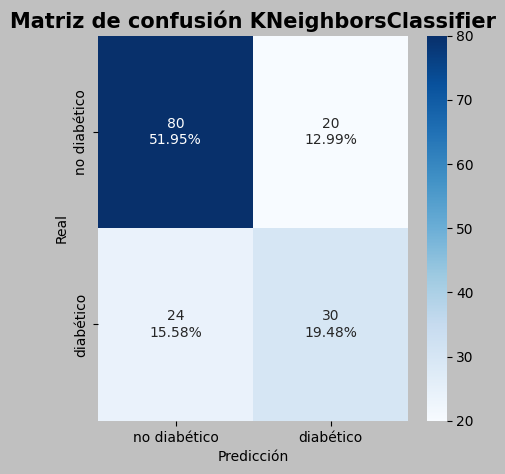

In [ ]:
view_matriz(model_knn, X_test, y_test, target_clases, "KNeighborsClassifier")

## Probando con varios valores de *'k'*

A continuación se prueba con varios vaores de K para intentar buscar el óptimo

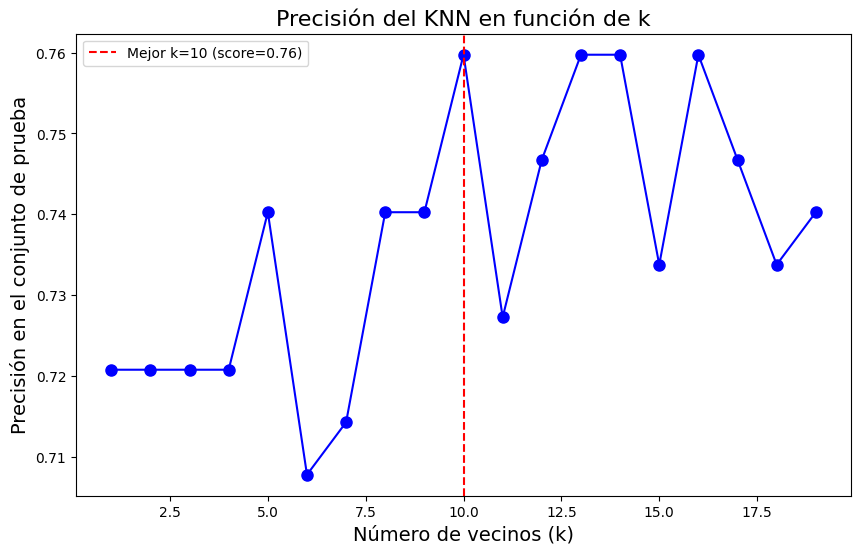

In [ ]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

# Graficar los scores en función del valor de k
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o', linestyle='-', color='b', markersize=8)

# Agregar etiquetas y título
plt.xlabel('Número de vecinos (k)', fontsize=14)
plt.ylabel('Precisión en el conjunto de prueba', fontsize=14)
plt.title('Precisión del KNN en función de k', fontsize=16)

# Mostrar la mejor precisión en el gráfico
best_k = k_range[scores.index(max(scores))]
best_score = max(scores)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Mejor k={best_k} (score={best_score:.2f})')

# Agregar leyenda
plt.legend(loc='best')
plt.show()

# DecisionTreeClassifier


Los árboles de decisión son algoritmos de machine learning  muy utilizados debido a su buen rendimiento y su explicabilidad. Sin embargo, un árbol de decisión no siempre tiene buen rendimiento, por lo que se proponen técnicas de ensamble de árboles de decisión aislados para generar un estimador más robusto que el estimador único por el que está conformado el ensamble.

Además, son propensos a sobre ajuste

## Modelo 1 - árbol con una profundidad igual a 1

In [ ]:
single_decision = DecisionTreeClassifier(max_depth=1, criterion = "entropy", random_state= 29)
single_decision = single_decision.fit(X_train, y_train)

### Visualización del árbol

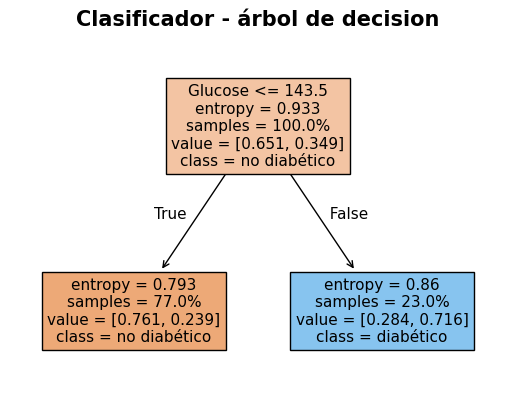

In [ ]:
plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    single_decision, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = ["Glucose", "BMI"], # Nombres de las variables utilizadas para entrenar.
    class_names = ["no diabético","diabético"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualiza las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.title("Clasificador - árbol de decision", fontsize=15, fontweight="bold")
plt.show()

### Evaluación del modelo

In [ ]:
print(classification_report(y_test,single_decision.predict(X_test),
                            target_names=["no diabético","diabético"]))

              precision    recall  f1-score   support

no diabético       0.76      0.90      0.82       100
   diabético       0.71      0.46      0.56        54

    accuracy                           0.75       154
   macro avg       0.74      0.68      0.69       154
weighted avg       0.74      0.75      0.73       154



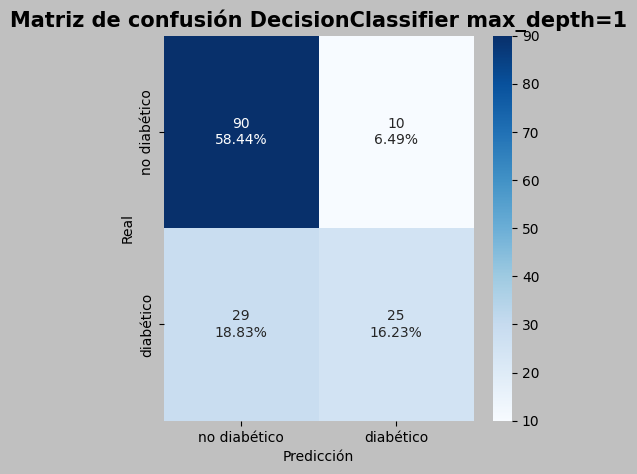

In [ ]:
view_matriz(single_decision, X_test, y_test, target_clases, "DecisionClassifier max_depth=1")

## Modelo 2 - árbol con mayor profundidad

In [ ]:
# Ahora se crea un árbol que sólo tenga 3 niveles de profundidad.
tree = DecisionTreeClassifier(max_depth=3, criterion = "entropy", random_sample = 29)
# Entrenamiento del modelo
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

### Evaluación del modelo

In [ ]:
print(classification_report(y_test,tree.predict(X_test),
                            target_names=["no diabético","diabético"]))

              precision    recall  f1-score   support

no diabético       0.70      0.94      0.80       100
   diabético       0.70      0.26      0.38        54

    accuracy                           0.70       154
   macro avg       0.70      0.60      0.59       154
weighted avg       0.70      0.70      0.65       154



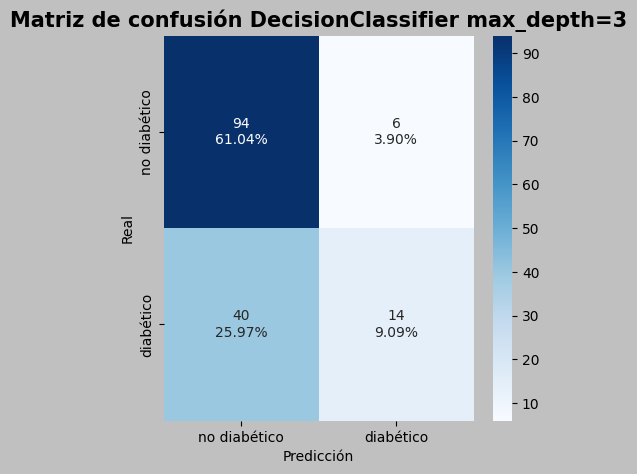

In [ ]:
view_matriz(tree, X_test, y_test, target_clases,
            "DecisionClassifier max_depth=3")

### Visualización del árbol

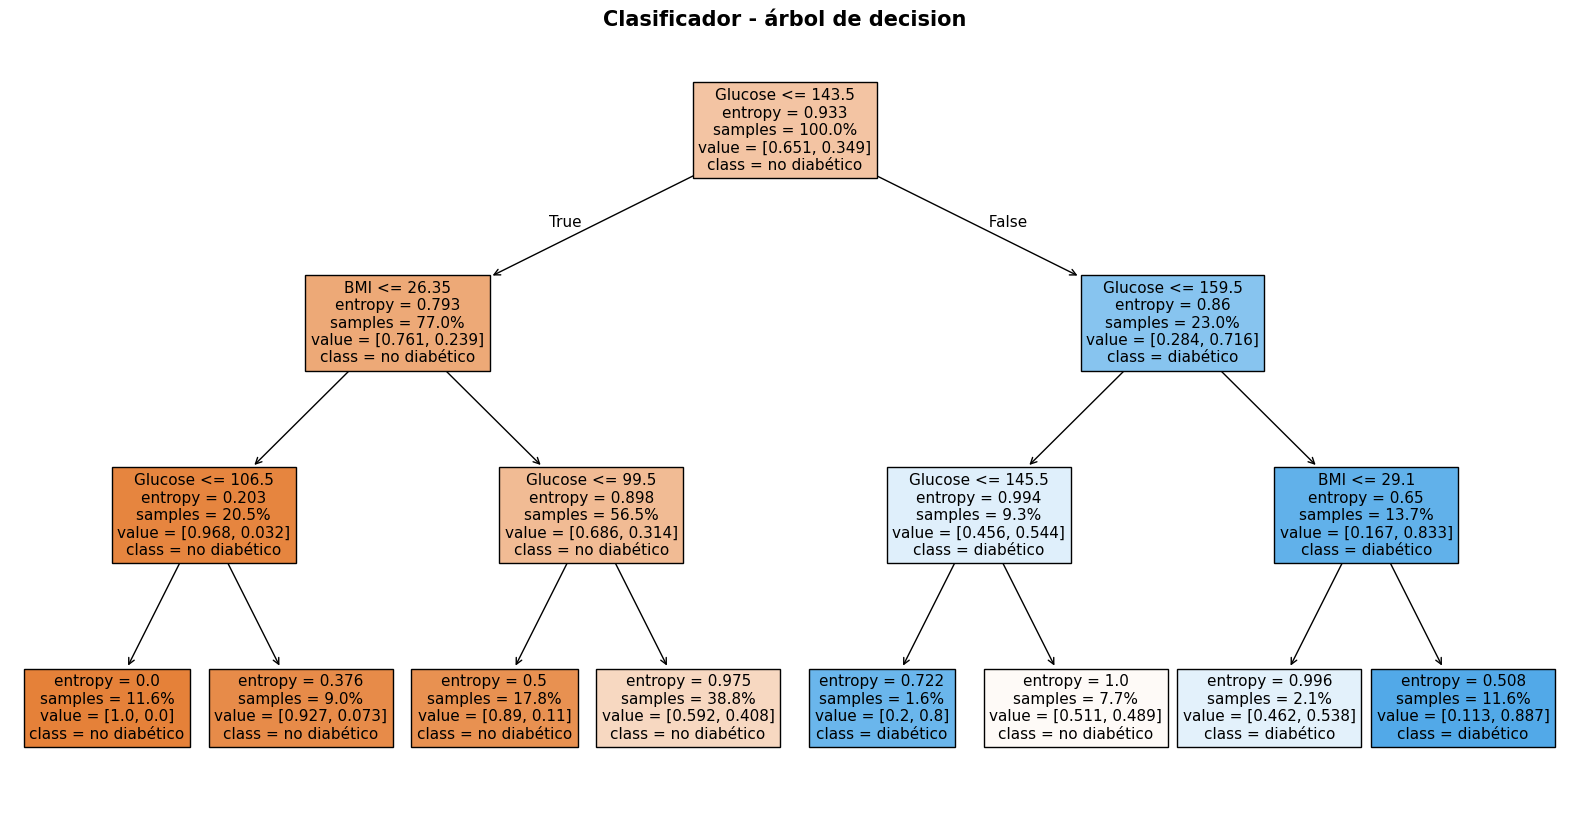

In [ ]:
plt.figure(figsize = (20,10))
plot_tree( # Función que permite visualizar el árbol de decisión ajustado.
    tree, # Objeto del árbol de decisión entrenado.
    feature_names = X_train.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["no diabético","diabético"], # Nombre de las clases que se están prediciendo.
    label = "all", # Etiqueta todas características de cada nodo.
    proportion = True, # Visualiza las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.title("Clasificador - árbol de decision", fontsize=15, fontweight="bold")
plt.show()

## Análisis rendimiento con otros valores de profundidad

In [ ]:
depths = range(1,10)
performances, performances_x, performances_recall, performances_f1, performances_precision = [], [], [], [], []
for depth in depths:
    # Crea el modelo
    current_tree = DecisionTreeClassifier(max_depth=depth, criterion = "entropy")
    # Calcula la métrica ROC_AUC
    roc_auc = cross_val_score(
          current_tree,
          diabetes.iloc[:,:-1],
          diabetes.Outcome,
          scoring="roc_auc"
      ).mean()
    performances.append(roc_auc)
    # Calcula el accuracy
    accuracy = cross_val_score(
          current_tree,
          diabetes.iloc[:,:-1],
          diabetes.Outcome,
          scoring="accuracy"
      ).mean()
    performances_x.append(accuracy)
    # Calcula el recall
    recall = cross_val_score(
          current_tree,
          diabetes.iloc[:,:-1],
          diabetes.Outcome,
          scoring="recall"
      ).mean()
    performances_recall.append(recall)
    # Calcula el F1-score
    f1_score = cross_val_score(
          current_tree,
          diabetes.iloc[:,:-1],
          diabetes.Outcome,
          scoring="f1"
      ).mean()
    performances_f1.append(f1_score)

    # Calcula precision
    precision_score = cross_val_score(
          current_tree,
          diabetes.iloc[:,:-1],
          diabetes.Outcome,
          scoring="precision"
      ).mean()
    performances_precision.append(precision_score)

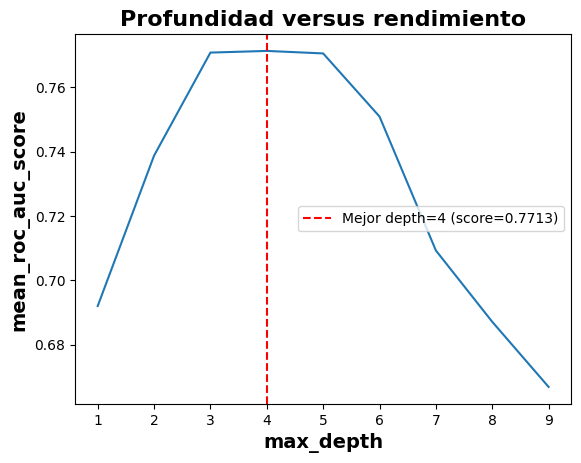

In [ ]:
plt.plot(depths, performances)
# Mostrar la mejor precisión en el gráfico
best_depth = depths[performances.index(max(performances))]
best_score = max(performances)
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Mejor depth={best_depth} (score={best_score:.4f})')

plt.xlabel("max_depth", fontsize=14, fontweight="bold")
plt.ylabel("mean_roc_auc_score", fontsize=14, fontweight="bold")
plt.title("Profundidad versus rendimiento", fontsize=16, fontweight="bold")
# Agregar leyenda
plt.legend(loc='right')
plt.show()

Ya se ha dejado en evidencia que un hiperparámetro que es posible ajustar en un árbol de decisión es la profundidad máxima. Se aprecia que se tiene un mejoramiento inicial del rendimiento al aumentar la profundidad, para después descender debido al sobreajuste.

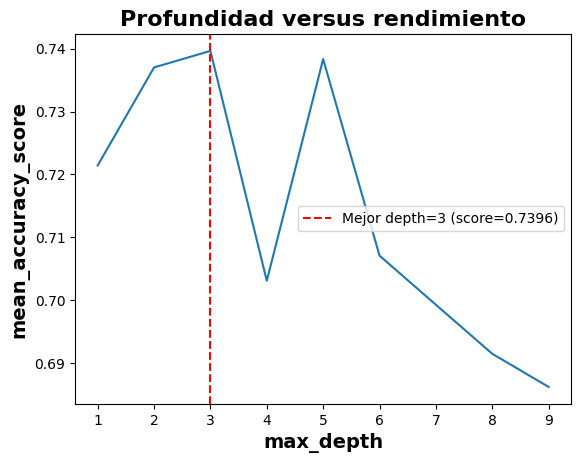

In [ ]:
plt.plot(depths, performances_x)
plt.xlabel("max_depth", fontsize=14, fontweight="bold")
plt.ylabel("mean_accuracy_score", fontsize=14, fontweight="bold")
plt.title("Profundidad versus rendimiento", fontsize=16, fontweight="bold")
# Mostrar la mejor precisión en el gráfico
best_depth = depths[performances_x.index(max(performances_x))]
best_score = max(performances_x)
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Mejor depth={best_depth} (score={best_score:.4f})')
# Agregar leyenda
plt.legend(loc='right')
plt.show()

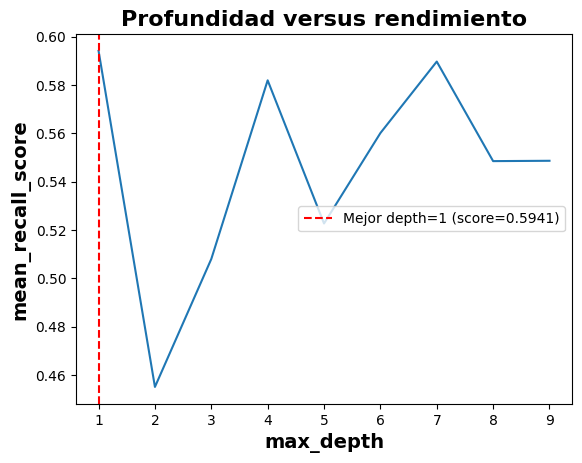

In [ ]:
plt.plot(
    depths,
    performances_recall
)
# Mostrar la mejor precisión en el gráfico
best_depth = depths[performances_recall.index(max(performances_recall))]
best_score = max(performances_recall)
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Mejor depth={best_depth} (score={best_score:.4f})')

plt.xlabel("max_depth", fontsize=14, fontweight="bold")
plt.ylabel("mean_recall_score", fontsize=14, fontweight="bold")
plt.title("Profundidad versus rendimiento", fontsize=16, fontweight="bold")

# Agregar leyenda
plt.legend(loc='right')
plt.show()

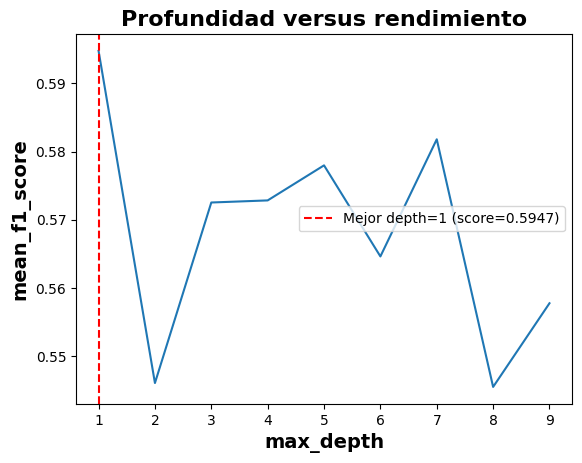

In [ ]:
plt.plot(
    depths,
    performances_f1
)
# Mostrar la mejor precisión en el gráfico
best_depth = depths[performances_f1.index(max(performances_f1))]
best_score = max(performances_f1)
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Mejor depth={best_depth} (score={best_score:.4f})')

plt.xlabel("max_depth", fontsize=14, fontweight="bold")
plt.ylabel("mean_f1_score", fontsize=14, fontweight="bold")
plt.title("Profundidad versus rendimiento", fontsize=16, fontweight="bold")
# Agregar leyenda
plt.legend(loc='right')
plt.show()

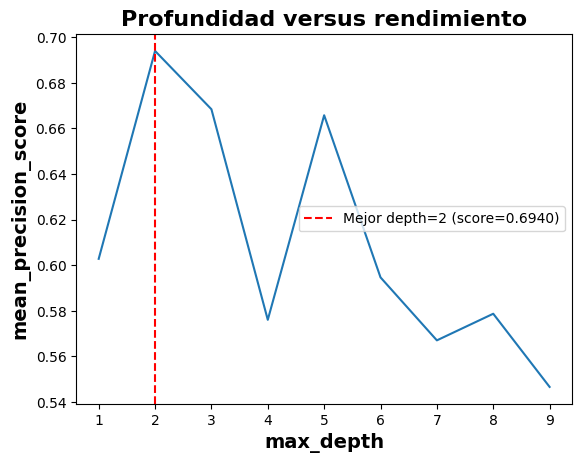

In [ ]:
plt.plot(
    depths,
    performances_precision
)
# Mostrar la mejor precisión en el gráfico
best_depth = depths[performances_precision.index(max(performances_precision))]
best_score = max(performances_precision)
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Mejor depth={best_depth} (score={best_score:.4f})')

plt.xlabel("max_depth", fontsize=14, fontweight="bold")
plt.ylabel("mean_precision_score", fontsize=14, fontweight="bold")
plt.title("Profundidad versus rendimiento", fontsize=16, fontweight="bold")

# Agregar leyenda
plt.legend(loc='right')
plt.show()

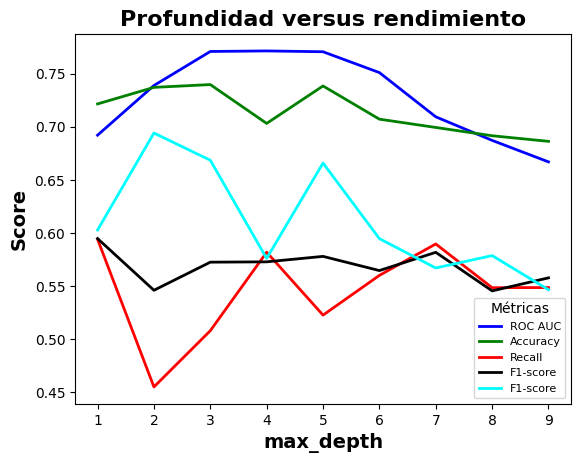

In [ ]:
# Graficar todas las métricas en el mismo gráfico con diferentes colores
plt.plot(depths, performances, label="ROC AUC", color="blue", linewidth=2)
plt.plot(depths, performances_x, label="Accuracy", color="green", linewidth=2)
plt.plot(depths, performances_recall, label="Recall", color="red", linewidth=2)
plt.plot(depths, performances_f1, label="F1-score", color="black", linewidth=2)
plt.plot(depths, performances_precision, label="F1-score", color="cyan", linewidth=2)

# Añadir etiquetas y título
plt.xlabel("max_depth", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=14, fontweight="bold")
plt.title("Profundidad versus rendimiento", fontsize=16, fontweight="bold")

# Añadir una leyenda para las diferentes métricas
plt.legend(title="Métricas", fontsize=8)

# Mostrar el gráfico
plt.show()
